<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Generation/%D0%9E%D1%87%D0%B8%D1%81%D1%82%D0%BA%D0%B0_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%BE%D1%82_%D0%B0%D1%80%D1%82%D0%B5%D1%84%D0%B0%D0%BA%D1%82%D0%BE%D0%B2_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмем базу картинок Mnist.
2. На картинках в случайных местах сделаем чёрные квадраты размера 8 на 8.
3. Создадим и обучим автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Задача добиться MSE < 0.005 на тестовой выборке

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, UpSampling2D, MaxPooling2D, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import random

%matplotlib inline

In [ ]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
# Нормировка данных
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [ ]:
# Изменение формы
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [ ]:
# Создание зашумленных изображений
def add_black_square(img):
    # Генерация случайных координат для квадрата
    x = random.randint(0, 23)
    y = random.randint(0, 23)

    # Добавление черного квадрата размера 8 на 8
    img[x:x+8, y:y+8] = 0
    return img

# Применение функции к каждому изображению в обучающей и тестовой выборке
x_train_noisy = np.array([add_black_square(np.copy(img)).reshape(28, 28, 1) for img in x_train])
x_test_noisy = np.array([add_black_square(np.copy(img)).reshape(28, 28, 1) for img in x_test])

In [ ]:
# Функция сборки сверточного автокодировщика
def create_base_ae(in_shape):
    # Энкодер, вход нейросети
    img_input = Input(in_shape)

    # Энкодер, первый блок
    # 1.1. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Снижение размерности и обобщение данных
    x = MaxPooling2D()(x)

    # Энкодер, второй блок
    # 2.1. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x)
    # 2.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x)


    # На выходе кодировщика и на входе декодировщика z - вектор латентного пространства
    # 2.5. Снижение размерности и обобщение данных
    z = MaxPooling2D()(x)


    # Декодер, первый блок
    # 1.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)
    # 1.2. Нормализация
    x = BatchNormalization()(x)
    # 1.3. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.4. Нормализация
    x = BatchNormalization()(x)
    # 1.5. Двумерная свертка
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    # 1.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, второй блок
    # 2.1. Транспонированная свертка - повышение размерности данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)
    # 2.2. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.3. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.4. Нормализация
    x = BatchNormalization()(x) # слой нормализации данных
    # 2.5. Двумерная свертка
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    # 2.6. Нормализация
    x = BatchNormalization()(x)

    # Декодер, финальный слой двумерной свертки, выдающий итоговое изображение
    outputs = Conv2D(in_shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    # Сборка модели, на входе оригинальное изображение, на выходе - сжатое-восстановленное
    model = Model(inputs=img_input, outputs=outputs)

    # Компиляция сети, назначение оптимизатора Adam + среднеквадратическая ошибка
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

    # Возврат готовой модели
    return model

In [ ]:
# Создание автокодировщика
autoencoder = create_base_ae(x_train.shape[1:])

# Обучение модели на зашумленных изображениях
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/25
938/938 [==============================] - 19s 15ms/step - loss: 0.0320 - val_loss: 0.0117
Epoch 2/25
938/938 [==============================] - 14s 15ms/step - loss: 0.0097 - val_loss: 0.0078
Epoch 3/25
938/938 [==============================] - 16s 17ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 4/25
938/938 [==============================] - 13s 14ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/25
938/938 [==============================] - 14s 15ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/25
938/938 [==============================] - 14s 15ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/25
938/938 [==============================] - 14s 14ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 8/25
938/938 [==============================] - 14s 15ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/25
938/938 [==============================] - 14s 15ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 10/25
938/938 [==============================] - 14s 15ms/step - loss: 0.003

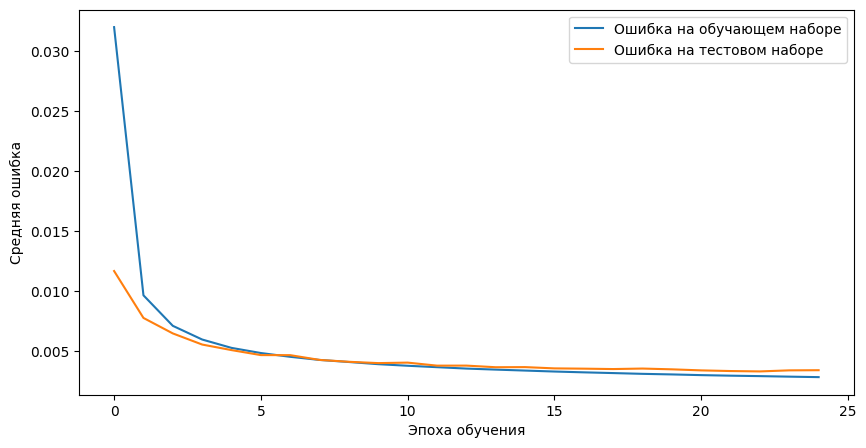

In [ ]:
# Вывод графика процесса обучения
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на тестовом наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4):
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')

    plt.show()

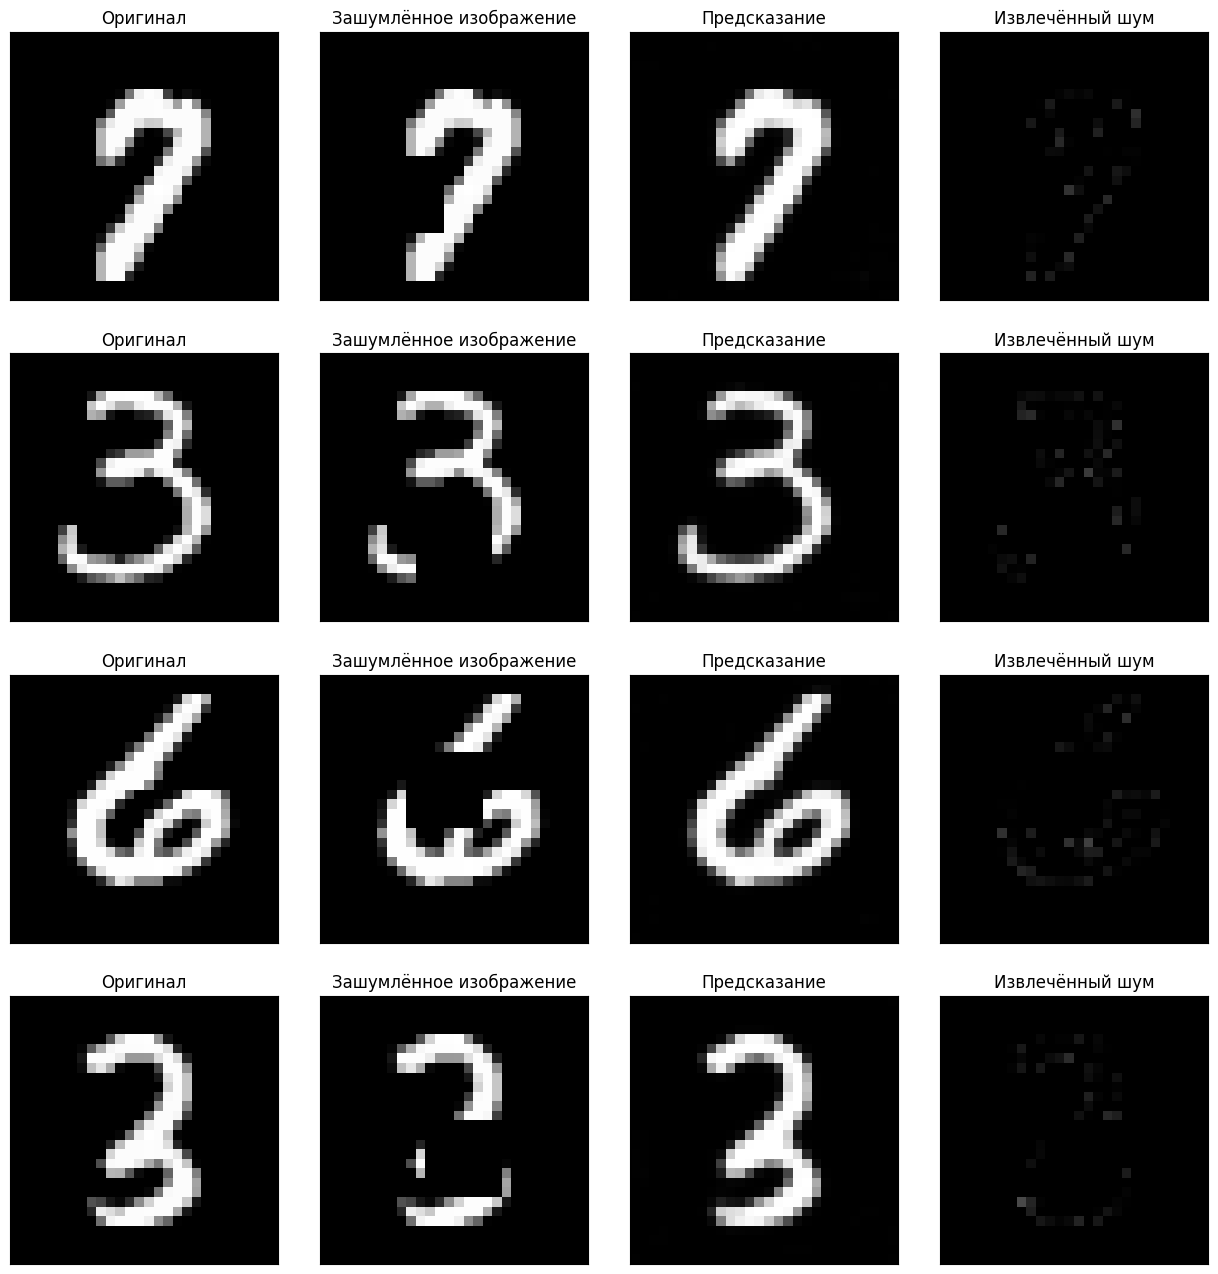

In [ ]:
# Получение предсказания автокодировщика на тестовой выборке
pred = autoencoder.predict(x_test,verbose=0)

# Сравнение исходных и восстановленных картинок из тестовой выборки
plot_images(x_test, x_test_noisy, pred)

In [ ]:
# Получение восстановленных изображений из зашумленных тестовых данных
restored_imgs = autoencoder.predict(x_test_noisy, verbose=0)

# Вычисление среднеквадратичной ошибки (MSE) между оригинальными и восстановленными изображениями
mse = np.mean(np.square(x_test - restored_imgs))
print('MSE на тестовой выборке:', mse)

MSE на тестовой выборке: 0.0034239544
